In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
bs = 64

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [5]:
path = untar_data(URLs.PETS); path

WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet')

In [6]:
path.ls()

[WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/annotations'),
 WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/'annotations'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images/Abyssinian_1.jpg'),
 WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images/Abyssinian_10.jpg'),
 WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images/Abyssinian_100.jpg'),
 WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images/Abyssinian_101.jpg'),
 WindowsPath('C:/Users/my/.fastai/data/oxford-iiit-pet/images/Abyssinian_102.jpg')]

In [9]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

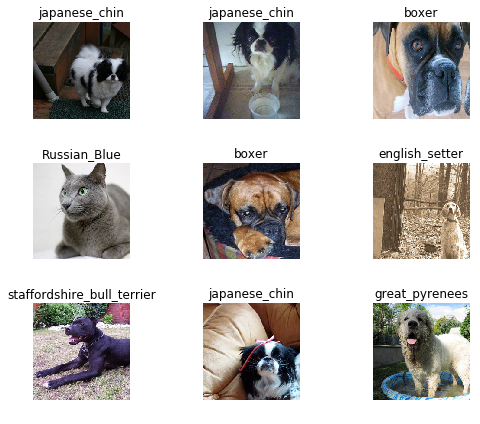

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [12]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

### Training: resnet34

In [13]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [14]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.341204,0.329538,0.100812,02:37
1,0.612666,0.298764,0.085927,02:23
2,0.389130,0.248280,0.073748,02:13
3,0.270583,0.252543,0.077808,02:03


In [16]:
learn.save('stage-1')

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

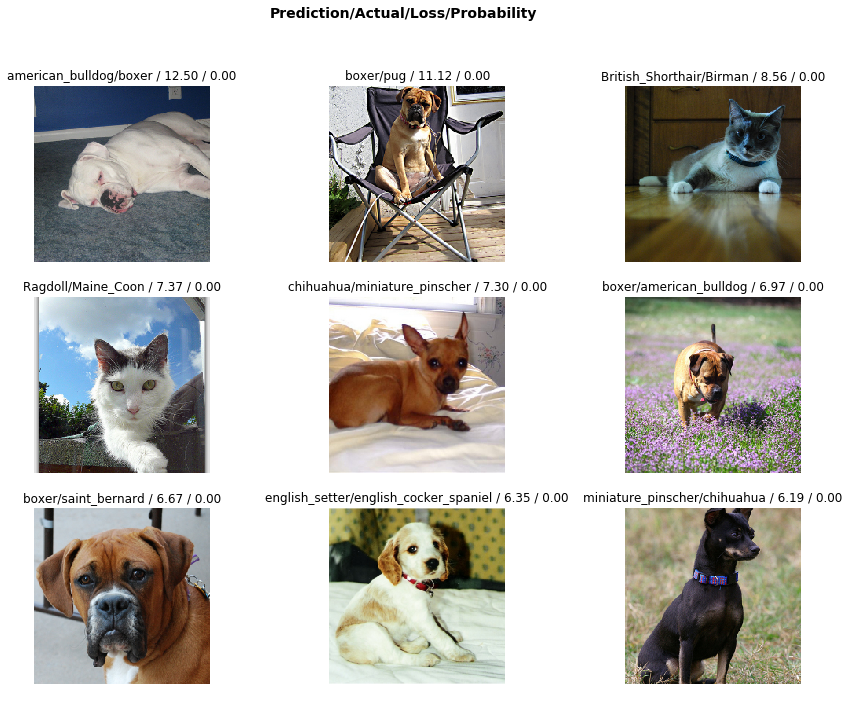

In [18]:
interp.plot_top_losses(9, figsize=(15,11))

In [19]:
doc(interp.plot_top_losses)

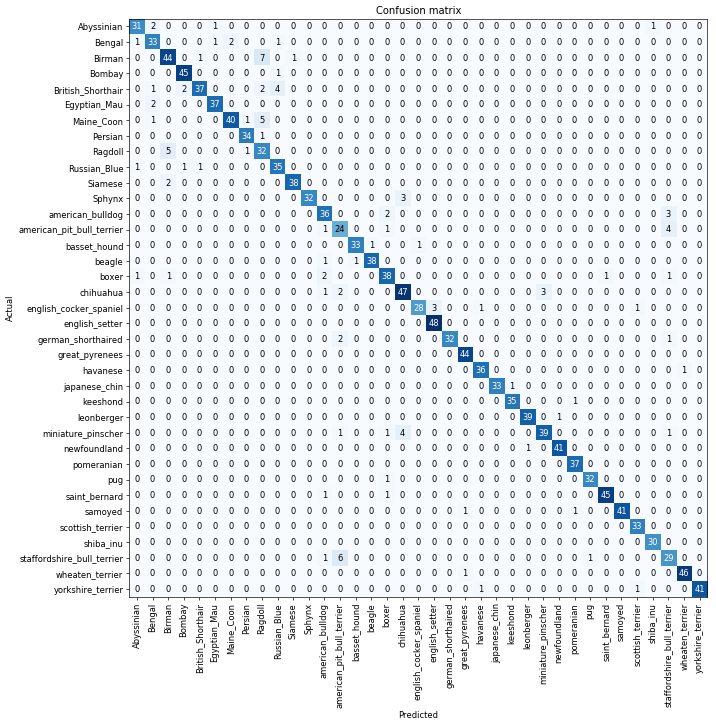

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=2)

[('Birman', 'Ragdoll', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('Maine_Coon', 'Ragdoll', 5),
 ('Ragdoll', 'Birman', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('Sphynx', 'chihuahua', 3),
 ('american_bulldog', 'staffordshire_bull_terrier', 3),
 ('chihuahua', 'miniature_pinscher', 3),
 ('english_cocker_spaniel', 'english_setter', 3),
 ('Abyssinian', 'Bengal', 2),
 ('Bengal', 'Maine_Coon', 2),
 ('British_Shorthair', 'Bombay', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Egyptian_Mau', 'Bengal', 2),
 ('Siamese', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'american_pit_bull_terrier', 2),
 ('german_shorthaired', 'american_pit_bull_terrier', 2)]

In [22]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.677776,0.377800,0.108254,02:30


In [24]:
learn.load('stage-1'); learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


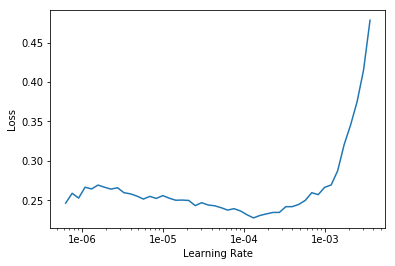

In [25]:
learn.recorder.plot()

In [26]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.229175,0.242122,0.077808,02:20
1,0.218289,0.236778,0.071719,02:19


### Training: resnet50

In [31]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=8).normalize(imagenet_stats)

In [32]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [33]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 4.00 GiB total capacity; 2.82 GiB already allocated; 26.97 MiB free; 2.93 GiB reserved in total by PyTorch)